## Import packages

In [1]:
import numpy as np
import simulators.jla_supernovae.jla_simulator as jla
import pydelfi.ndes as ndes
import pydelfi.delfi_edit_2 as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
import pylab as plt
import pyccl as ccl
import scipy
from scipy.interpolate import interp1d

import matplotlib
%matplotlib inline

import time
import importlib

print("CCL version you are using:",ccl.__version__)

CCL version you are using: 2.1.0


In [3]:
importlib.reload(delfi)

<module 'pydelfi.delfi_edit_2' from '/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/pydelfi/delfi_edit_2.py'>

In [4]:
from mpi4py import MPI

In [5]:
font_config = {"size" : 10,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=True)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=5) 
matplotlib.rc("axes", titlesize="medium") 

# Make the figures bigger in the notebook
matplotlib.rc("figure", dpi=150)

color_map = plt.get_cmap("tab10")

paper_textwidth = 7.125
fig_size = (paper_textwidth/2, 2.6)

plot_adjust = dict(left=0.2, top=0.9, bottom=0.2)

In [6]:
import simulators.mass_function_n_counts.simulator_trapz_tinker_2params as n_counts_simulator
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_tinker_2params' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_tinker_2params.py'>

In [7]:
log10masses = np.linspace(14, 15.5, num = 4)
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)
log10masses_2d = np.stack((log10masses[:-1], log10masses[1:]))

In [8]:
lower = np.array([0.1125, 0.65])
upper = np.array([0.1275, 0.85])
prior = priors.Uniform(lower, upper)

In [9]:
theta_fiducial = np.array([0.1197, 0.76])

In [10]:
N_countsSimulator = n_counts_simulator.Model(log10masses, z_min, z_max)
N_counts = N_countsSimulator.N_counts
#N_counts = N_countsSimulator.simulation(theta_fiducial, 1)
N_counts

array([2.01375933e+04, 6.15932449e+04, 7.92155533e+04, 7.05138175e+04,
       5.00615557e+04, 2.66747919e+03, 6.24078572e+03, 5.83486556e+03,
       3.60888575e+03, 1.70548356e+03, 1.21730998e+02, 1.76398359e+02,
       9.32196154e+01, 2.99497101e+01, 6.76248388e+00])

In [11]:
np.round(N_counts).astype(int)

array([20138, 61593, 79216, 70514, 50062,  2667,  6241,  5835,  3609,
        1705,   122,   176,    93,    30,     7])

In [12]:
t1 = time.process_time()
N_counts = N_countsSimulator.simulation(theta_fiducial, 1)
t2 = time.process_time()
print('time per 1 sim: '+ str(t2-t1))

time per 1 sim: 0.48227304700000007


## Version 2

(1) Compute fiducial number of counts N for different redshift bins (for a range of masses, 14 to 15.5)

(2) Draw N samples from joint redshift-mass distribution

(3) Create mock catalogue

In [13]:
import simulators.mass_function_n_counts.simulator_trapz_tinker_2params_mock_catalogue_v2_og_bins_2 as n_counts_simulator_2

In [14]:
importlib.reload(n_counts_simulator_2)

<module 'simulators.mass_function_n_counts.simulator_trapz_tinker_2params_mock_catalogue_v2_og_bins_2' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_tinker_2params_mock_catalogue_v2_og_bins_2.py'>

In [15]:
log10masses = np.linspace(14, 15.5, num = 2)
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)
log10masses_2d = np.stack((log10masses[:-1], log10masses[1:]))

In [16]:
N_countsSimulator2 = n_counts_simulator_2.Model(log10masses, z_min, z_max)
N_by_z = N_countsSimulator2.N_counts[0]
N_by_z.astype(int)

array([22926, 68010, 85143, 74152, 51774])

In [17]:
cosmo_ccl = N_countsSimulator2.cosmo(theta_fiducial)

In [18]:
t1 = time.process_time()
N_sims = N_countsSimulator2.simulation(theta_fiducial, 4)
t2 = time.process_time()
print('time per 1 sim: '+ str(t2-t1))

time per 1 sim: 11.448095856


In [19]:
N_sims

array([20126, 62419, 78960, 70743, 49782,  2757,  6393,  5880,  3618,
        1736,   132,   170,    85,    28,     4])

In [20]:
def simulator(theta, seed, simulator_args, batch):
    return N_countsSimulator2.simulation(theta, seed)

simulator_args = None

In [21]:
def compressor(data, compressor_args):
    return data
compressor_args=None

In [22]:
N_counts_data =  N_countsSimulator.N_counts
#N_counts_data = N_sims
N_counts_data

array([2.01375933e+04, 6.15932449e+04, 7.92155533e+04, 7.05138175e+04,
       5.00615557e+04, 2.66747919e+03, 6.24078572e+03, 5.83486556e+03,
       3.60888575e+03, 1.70548356e+03, 1.21730998e+02, 1.76398359e+02,
       9.32196154e+01, 2.99497101e+01, 6.76248388e+00])

In [23]:
n_params = len(theta_fiducial)
print(n_params)
n_data_points = len(N_counts_data)
print(n_data_points)

2
15


In [24]:
NDEs = [ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=0),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
       ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=n_params, n_data=n_data_points, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=2)]



In [25]:
MPI.Comm.Reduce

<method 'Reduce' of 'mpi4py.MPI.Comm' objects>

In [29]:
DelfiEnsemble = delfi.Delfi(N_counts_data, prior, NDEs,
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_{cdm}h^{2}', '\\sigma_{8}'],
                            results_dir = "simulators/mass_function_n_counts/results_mock_trial_long_sims_fiducial_mpi_2/",
                            n_procs=20, comm = MPI.COMM_SELF, red_op=MPI.PROD)
                          
    

In [30]:
n_initial = 100
n_batch = 100 
n_populations = 10 

Sampling approximate posterior...
Done.
Removed no burn in


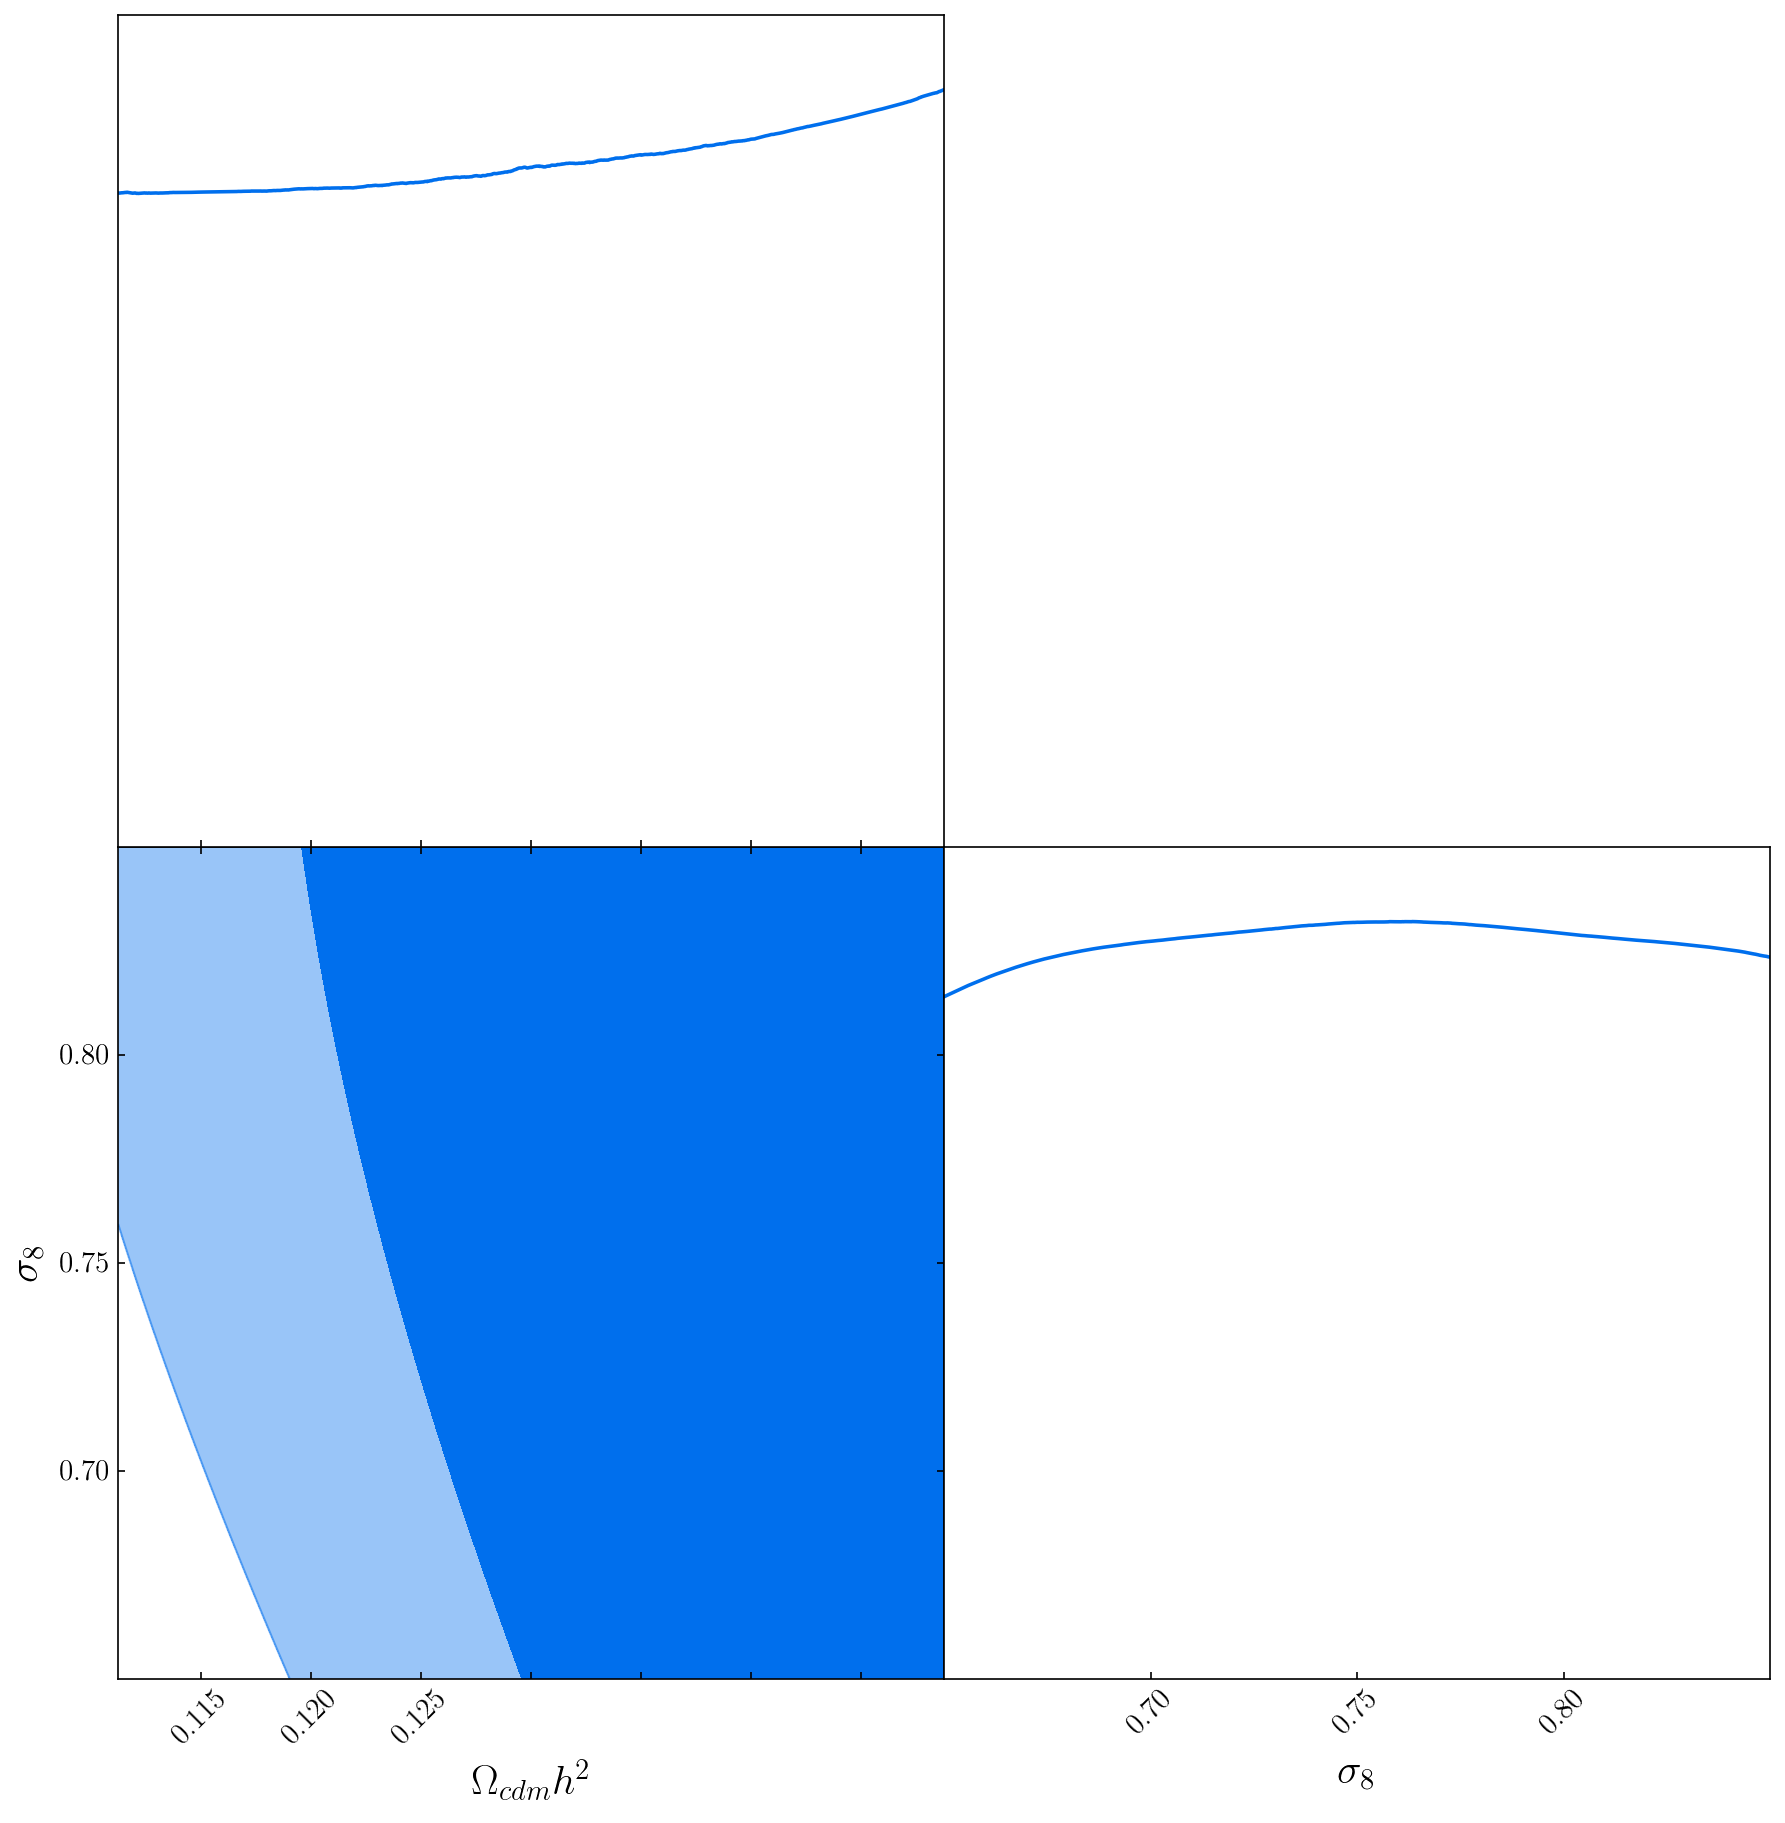

Population 1/10
Sampling proposal density...
emcee: Exception while calling your likelihood function:
  params: [0.12357766 0.5713358 ]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/home/aizhana/.local/lib/python3.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/pydelfi/delfi_edit_2.py", line 458, in <lambda>
    self.emcee_sample(log_target = lambda x: self.log_geometric_mean_proposal_stacked(x, self.data),
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/pydelfi/delfi_edit_2.py", line 246, in log_geometric_mean_proposal_stacked
    return 0.5 * (self.log_likelihood_stacked(x, data) + 2 * self.prior.logpdf(np.atleast_2d(x)) )
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/pydelfi/delfi_edit_2.py", line 226, in log_likelihood_stacked
    L += self.stacking_weights[n]*np.exp(self.nde[n].eval((np.atleast_2d((theta-self.p_mean)/self.p_std), np.atleast_2d((data-self.x_mean)/self.x_std)), self.sess))
  File "/home/aizhana/.conda/envs/fast-mpi4py/

KeyboardInterrupt: 

In [31]:
DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20,
                                  save_intermediate_posteriors=True)

In [26]:
x0 = DelfiEnsemble.posterior_samples[np.random.choice(np.arange(len(DelfiEnsemble.posterior_samples)), 
                                                       p=DelfiEnsemble.posterior_weights.astype(np.float32)/sum(DelfiEnsemble.posterior_weights), 
                                                       replace=False, size=DelfiEnsemble.nwalkers),:]
posterior_samples, posterior_weights, log_prob = DelfiEnsemble.emcee_sample(x0=x0)



Removed no burn in


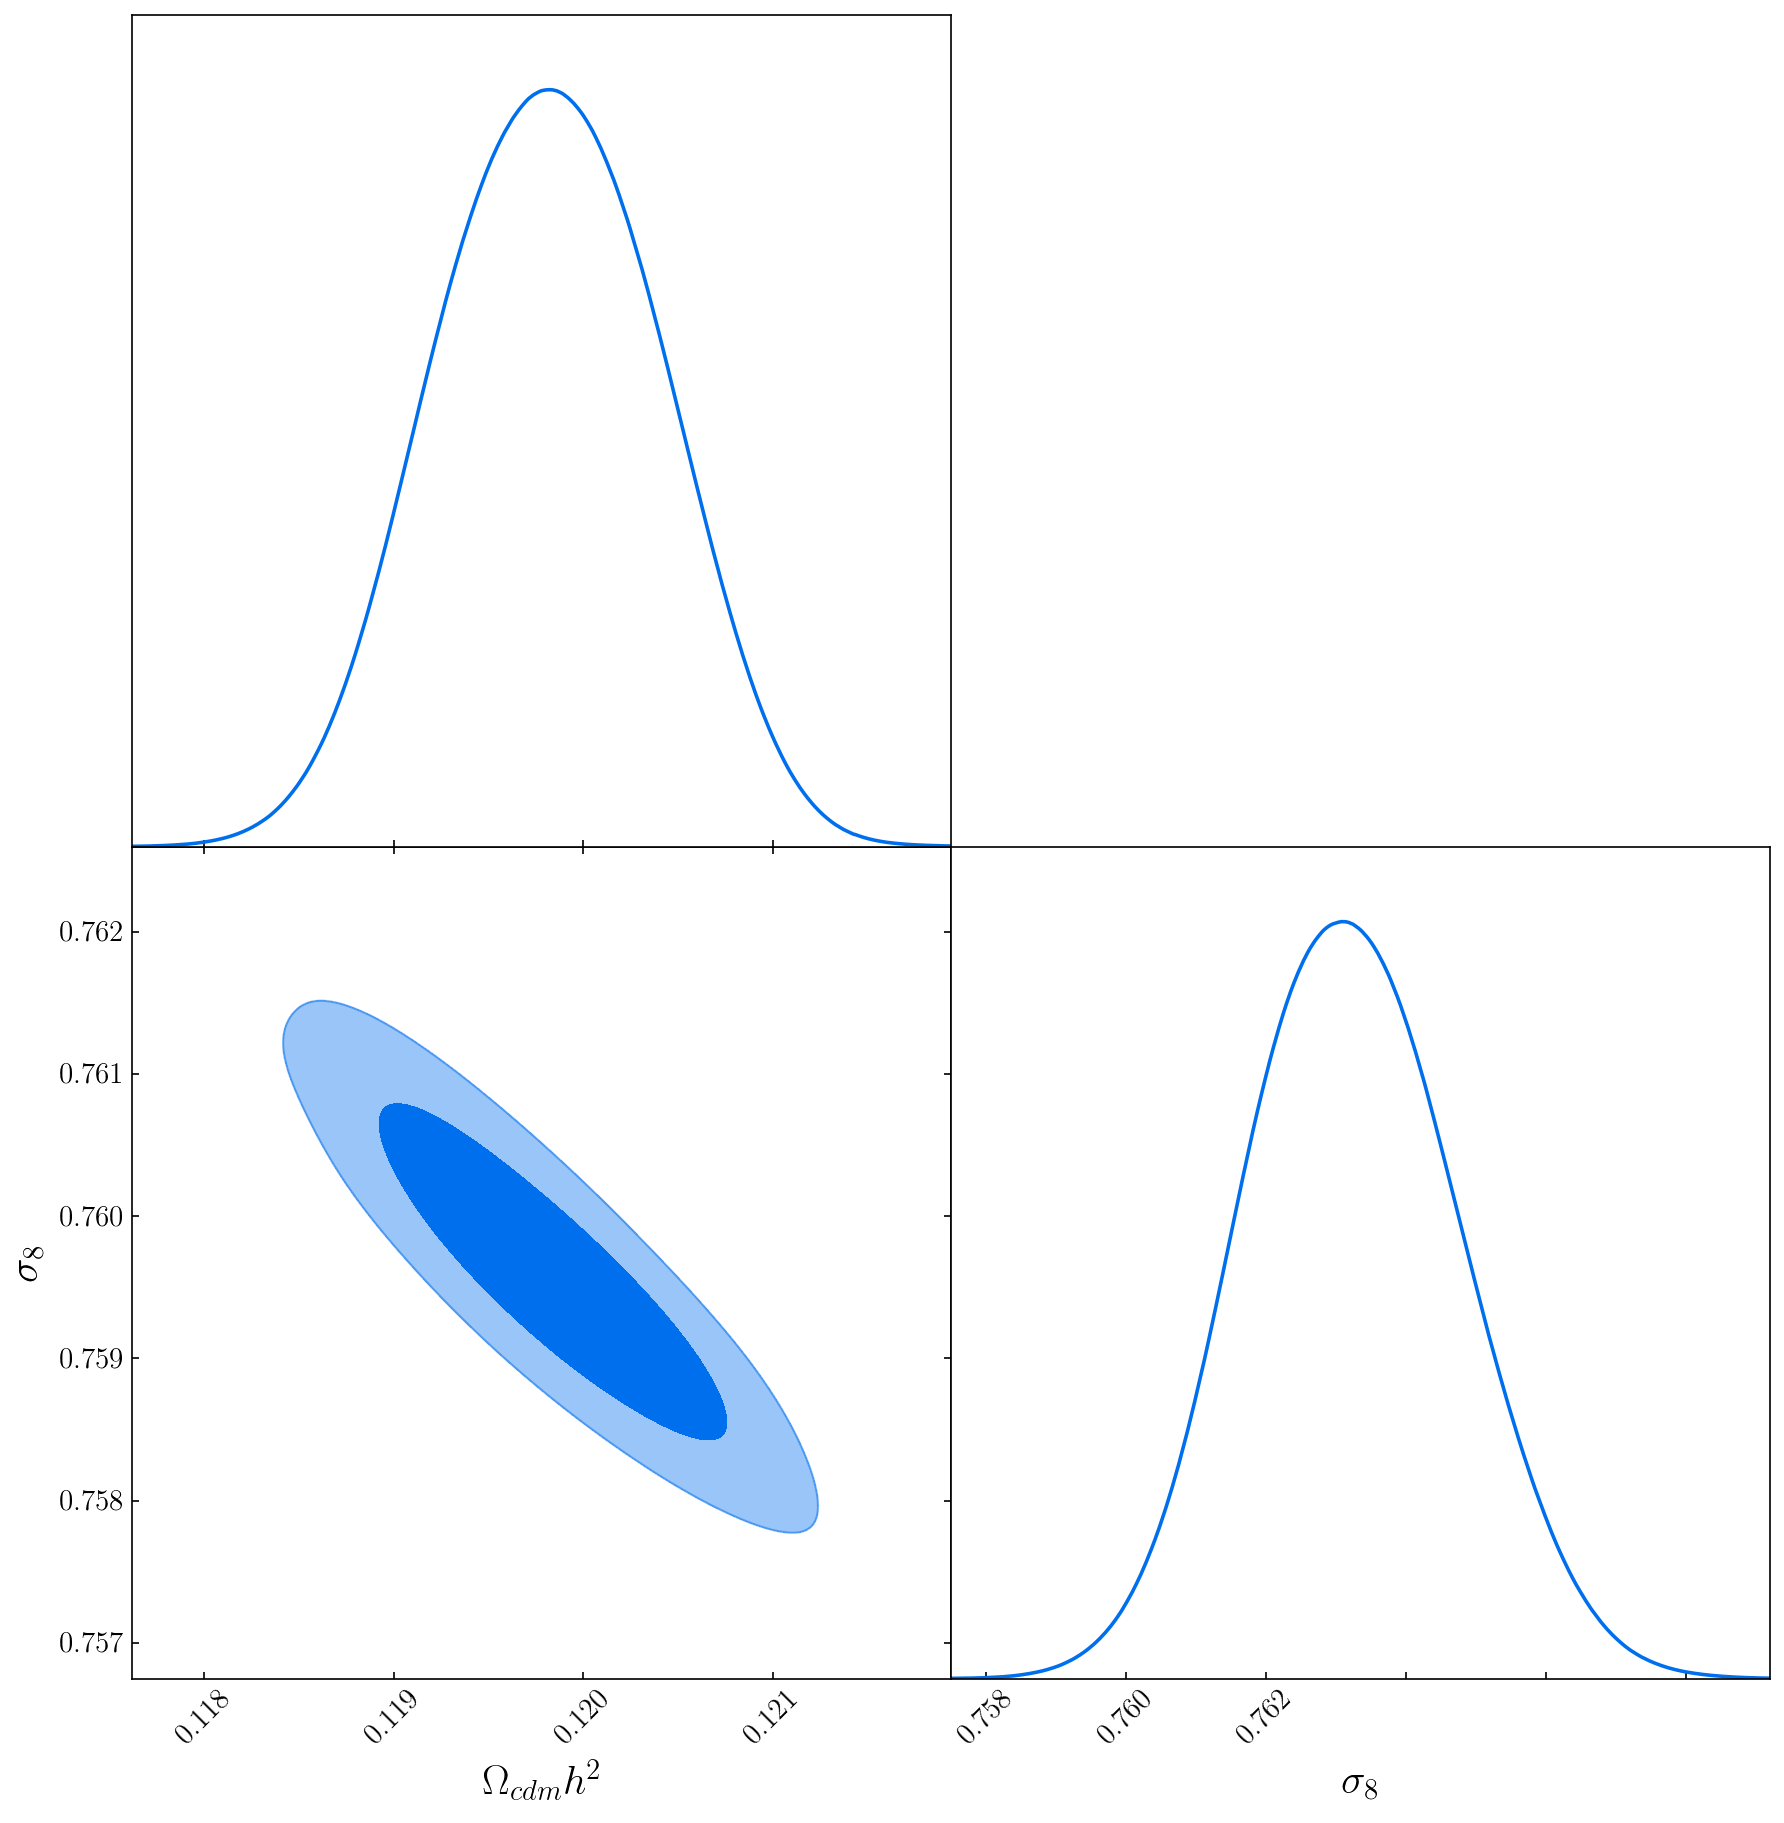

In [27]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples], weights=[posterior_weights])

In [28]:
def weighted_params(posterior_samples, posterior_weights):
    results_means = np.average(posterior_samples, axis =0, weights = posterior_weights)
    
    # https://stats.stackexchange.com/questions/6534/how-do-i-calculate-a-weighted-standard-deviation-in-excel
    M_nonzero = len(np.nonzero(posterior_weights)[0])
    numerator = np.sum(((posterior_samples - results_means)**2)*posterior_weights.reshape((posterior_samples.shape[0], 1)), axis = 0)
    denominator = (M_nonzero-1)*np.sum(posterior_weights)/M_nonzero
    
    results_stdev = np.sqrt(numerator/denominator)
    
    return results_means, results_stdev

In [29]:
results_means_0, results_stdev_0 = weighted_params(posterior_samples, posterior_weights)
print('fiducial params' + str(theta_fiducial))
print(results_means_0)
print(results_stdev_0)

fiducial params[0.1197 0.76  ]
[0.11981536 0.75960989]
[0.00059022 0.0007647 ]


In [30]:
print('Upper and lower 2\sigma-limits:')
print('On \omega_cdm: [' + str((results_means_0 - 2*results_stdev_0)[0]) + ', ' + str((results_means_0 + 2*results_stdev_0)[0]), ']')
print('On \sigma_8: [' + str((results_means_0 - 2*results_stdev_0)[1]) + ', ' + str((results_means_0 + 2*results_stdev_0)[1]), ']')


Upper and lower 2\sigma-limits:
On \omega_cdm: [0.11863491519403387, 0.12099579794892652 ]
On \sigma_8: [0.7580804851392089, 0.7611392933978163 ]


In [31]:
np.savetxt(DelfiEnsemble.results_dir+'posterior_samples.npy', posterior_samples)
np.savetxt(DelfiEnsemble.results_dir+'posterior_weights.npy', posterior_weights)

In [32]:
DelfiEnsemble.results_dir

'simulators/mass_function_n_counts/results_mock_trial_long_sims_fiducial/'